# Process specifications

Dynamically adjusting parameters in a process to meet a specification is critical in designing a production process, and even more so when its under uncertaintly. BioSTEAM groups process specifications into two categories: analytical specifications, and numerical specifications. As the name suggests, an analytical specification is directly solved within a single loop of a system. A numerical specification, on the other hand, is solved numerically by rerunning a unit operation or even by reconverging a recycle system. The following real world examples will explain this in detail.

## Analytical specifications

### Denature ethanol fuel in a bioethanol process

Use a ProcessSpecifcation object to define the amount of denaturant to add according to the flow of bioethanol. The final bioethanol product must be 2 wt. % denaturant:

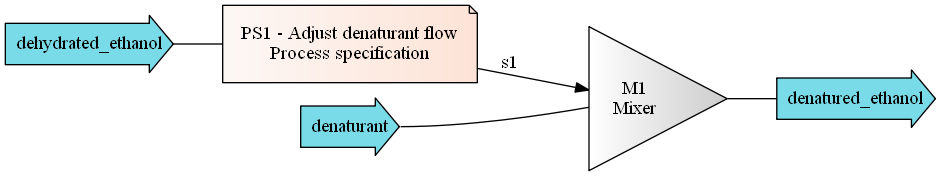

Mixer: M1
ins...
[0] s1  from  ProcessSpecification-PS1
    phase: 'l', T: 340 K, P: 101325 Pa
    composition: Water    0.001
                 Ethanol  0.999
                 -------  9.05e+07 kg/hr
[1] denaturant
    phase: 'l', T: 298.15 K, P: 101325 Pa
    composition: Octane  1
                 ------  1.85e+06 kg/hr
outs...
[0] denatured_ethanol
    phase: 'l', T: 339.32 K, P: 101325 Pa
    composition: Water    0.00098
                 Ethanol  0.979
                 Octane   0.02
                 -------  9.23e+07 kg/hr


In [1]:
from biosteam import settings, Stream, units, main_flowsheet

# First name a new flowsheet
main_flowsheet.set_flowsheet('mix_ethanol_with_denaturant')

# Set the thermodynamic property package.
# In an actual process, much more chemicals
# would be defined, but here we keep it short.
settings.set_thermo(['Water', 'Ethanol', 'Octane'])

# Assume 40 million gal ethanol produced a year
# with 330 operating days
ethanol = Stream('dehydrated_ethanol', T=340,
                 Water=0.1, Ethanol=99.9, units='kg/hr')
operating_days_per_year = 330
ethanol.F_vol = 40e6 / operating_days_per_year
denaturant = Stream('denaturant', Octane=1)

# Create the process specification function.
def adjust_denaturant_flow():
    denaturant_over_ethanol_flow = 0.02 / 0.98 # A mass ratio
    denaturant.imass['Octane'] = denaturant_over_ethanol_flow * ethanol.F_mass

# Create a ProcessSpecification object that runs the function
# as a unit operation. The inlet and outlet stream is just there
# to specify its location along the flow sheet.    
PS1 = units.ProcessSpecification('PS1', ins=ethanol,
                                 specification=adjust_denaturant_flow)
M1 = units.Mixer('M1', ins=(PS1-0, denaturant), outs='denatured_ethanol')

# Now create the system, simulate, and check results. 
system = main_flowsheet.create_system()
system.simulate()
system.diagram()
M1.show(composition=True, flow='kg/hr')

### Preparing corn slurry in a conventional dry-grind process

The solids content of a corn slurry fed to a conventional dry-grind corn ethanol plant is typically about 32 wt. %. Use a ProcessSpecification object to adjust the flow rate of water mixed with the milled corn for such that the slurry is 32 wt. %:

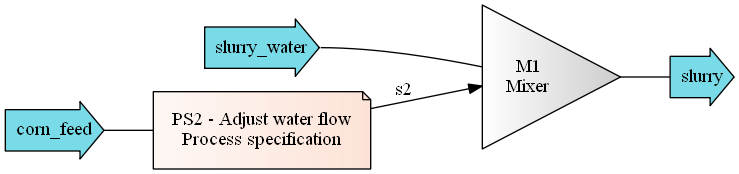

Mixer: M1
ins...
[0] slurry_water
    phase: 'l', T: 298.15 K, P: 101325 Pa
    composition: Water  1
                 -----  2.87e+07 kg/hr
[1] s2  from  ProcessSpecification-PS2
    phase: 'l', T: 298.15 K, P: 101325 Pa
    composition: Starch  0.62
                 Oil     0.04
                 Fiber   0.19
                 Water   0.15
                 ------  1.73e+07 kg/hr
outs...
[0] slurry
    phase: 'l', T: 298.15 K, P: 101325 Pa
    composition: Starch  0.233
                 Oil     0.0151
                 Fiber   0.0715
                 Water   0.68
                 ------  4.61e+07 kg/hr


In [2]:
import biosteam as bst
from biosteam import units

# First name a new flowsheet
bst.main_flowsheet.set_flowsheet('corn_slurry_example')

# Create a general chemicals to represent the 
# components of corn.
Starch = bst.Chemical.blank('Starch', phase='s')
Fiber = bst.Chemical.blank('Fiber', phase='s')
Oil = bst.Chemical('Oil', search_ID='Oleic_acid')
Water = bst.Chemical('Water')

# The exact properties are not important for 
# the example, so just assume its like water at
# 25 C and 1 atm.
Starch.default()
Fiber.default()

# Set the thermodynamic property package.
# In an actual process, much more chemicals
# would be defined, but here we keep it short.
bst.settings.set_thermo([Starch, Oil, Fiber, Water])

# A typical dry grind process may produce
# 40 million gal of ethanol a year with a
# yield of 2.7 gal ethanol per bushel of corn.
corn_flow_per_year = 40e6 / 2.7 # In bushels
days_per_year = 365
operating_days_per_year = 330
corn_flow_per_day = corn_flow_per_year * days_per_year / operating_days_per_year

# The corn kernel iscomposed of starch (62%), protein and fiber (19%),
# water (15%), and oil (4%).
corn_feed = bst.Stream('corn_feed', Starch=62, Fiber=19, Water=15, Oil=4, units='kg/hr')
corn_feed.set_total_flow(corn_flow_per_day, units='bu/day')

# Water that will be mixed with the milled corn to create the slurry.
slurry_water = bst.Stream('slurry_water', Water=1)

# Create the process specification function.
def adjust_water_flow():
    F_mass_moisture = corn_feed.imass['Water']
    F_mass_solids = corn_feed.F_mass - F_mass_moisture
    slurry_water.F_mass = F_mass_solids * (1 - 0.32) / 0.32 - F_mass_moisture

# Create a ProcessSpecification object that runs the function
# as a unit operation. The inlet and outlet stream is just there
# to specify its location along the flow sheet.
PS2 = units.ProcessSpecification('PS2', ins=corn_feed, specification=adjust_water_flow)
M1 = units.Mixer('M1',
                 ins=(slurry_water, PS2-0),
                 outs='slurry')

# Now create the system, simulate, and check results. 
system = bst.main_flowsheet.create_system()
system.simulate()
system.diagram()
M1.show(flow='kg/hr', composition=True)

## Numerical specifications

### Flash design specification

Let's say we have a mixture of water, ethanol and propanol and we would like to evaporate 60% of the liquid by mass (not by mol). We can solve this problem numerically by testing whether the specification is met at a given temperature:

C:\Users\yoelr\OneDrive\Code\biosteam\biosteam\units\_flash.py:314: DesignWarning: @Flash F1: Vertical vessel weight (806.4 lb) is out of bounds (4200 to 1e+06 lb).
  if isVertical: self._design_vertical_vessel()
C:\Users\yoelr\OneDrive\Code\biosteam\biosteam\units\_flash.py:314: DesignWarning: @Flash F1: Vertical vessel length (11.5 ft) is out of bounds (12 to 40 ft).
  if isVertical: self._design_vertical_vessel()


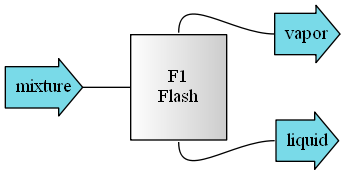

liquid mass fraction:  60%


In [3]:
import biosteam as bst
from biosteam import units

# First name a new flowsheet
bst.main_flowsheet.set_flowsheet('flash_specification_example')

# Set the thermodynamic property package.
# In an actual process, much more chemicals
# would be defined, but here we keep it short.
bst.settings.set_thermo(['Water', 'Ethanol', 'Propanol'])

# Feed stream
mixture = bst.Stream('mixture', T=340,
                      Water=1000, Ethanol=1000, Propanol=1000,
                      units='kg/hr')

# Create a flash vessel
F1 = units.Flash('F1',
                 ins=mixture,
                 outs=('vapor', 'liquid'),
                 T=373, P=101325)

# Objective function where f(T) = 0
# at a liquid composition of 90 wt. % water.
def f(T):
    F1.T = T
    F1._run()
    feed = F1.ins[0]
    vapor = F1.outs[0]
    V = vapor.F_mass / feed.F_mass 
    return  V - 0.60

# Set a numerical specification which solves the objective function when called.
# BioSTEAM provides some basic classes for numerical specifications.
F1.numerical_specification = bst.utils.BoundedNumericalSpecification(f, 351.39, 373.15)

# Now create the system, simulate, and check results. 
system = bst.main_flowsheet.create_system()
system.simulate()
system.diagram()
print('liquid mass fraction: ', format(F1.outs[0].F_mass / mixture.F_mass, '.0%'))